>> Hugo Rodrigues Pessoni

>> 202204590

# Processamento de Linguagem Natural (NLP)

Professor: Arlindo Galvão

Data: 03/09/2024

## Cronograma

* Parte I: N-Gram Language Model
    
* Parte II: Character-Level RNN Language Model

## OBS
Deixar registrado as repostas nas saídas das celulas do notebook de submissão.

## N-Gram Language Model

>> O N-Gram é um técnica de modelagem de linguagem que usa a porbabilidade de ocorrência de uma sequencia de palavras com base em N palavras anteriores, esse N significa o numero de palvras usadas no contexto. Por exemplo se eu uso N=2 significa utilizar 2 palavras anteriores para prever a próxima. Essa técnica cria uma tabela de frequências das sequencias de palavras no texto de train e utiliza essas frequancias para prever a próxima palavra. Pode ser bom para encontrar padrões específicios, porém tem dificuldades com contextos longos. Bora lá! 

In [105]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [284]:
class NGramLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim) #mapeia cada palavra do vocabulário para um vetor de embeddings com o tamanho embedding_dim.
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        #self.dropout = nn.Dropout(p=0.3)  # Dropout de 30%
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs): #inputs são palavras no formato de índices
        embeds = self.embeddings(inputs).view((1, -1)) # índices são convertidos em embeddings e depois transformados em um vetor plano
        out = F.relu(self.linear1(embeds))
        #out = self.dropout(out) #Dropout
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs
    
    #função para calcular similaridade de cosseno entre duas palavras
    def word_similarity(self, word1, word2, word_to_ix):
        # índices das palavras
        word1_idx = torch.tensor([word_to_ix[word1]], dtype=torch.long)
        word2_idx = torch.tensor([word_to_ix[word2]], dtype=torch.long)

        # embeddings das duas palavras
        word1_embed = self.embeddings(word1_idx).squeeze(0)
        word2_embed = self.embeddings(word2_idx).squeeze(0)

        # similaridade de cosseno
        cosine_similarity = F.cosine_similarity(word1_embed, word2_embed, dim=0)
        return cosine_similarity.item()
    

    def generate(self, context, word_to_ix, ix_to_word, max_tokens):

        '''responsável por criar uma sequencia de texto com base em um n-grama de train. 
        Ela vai começar escolhendo uma sequencia inicial de N palavras (word-level) e depois vai prevendo as próximas palavras 
        com base nas probabilidades de sequencia aprendidas durante o train. 
        A cada passo, o modelo usa o final dessa sequencia gerada para prever o próximo elemento e aasim por adiante, 
        até atingir o tamanho desejado.'''

        result = context[:]  # inicia com o contexto dado
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long) #converte os indices em tensores
        num_tokens = sum(len(w) for w in context) # número inicial de tokens no contexto
        
        # gera palavras/tokens até atingir o número máximo de tokens
        while num_tokens < max_tokens:
            
            # probabilidades da próxima palavra
            with torch.no_grad():  # sem cálculo de gradientes
                log_probs = self.forward(context_idxs)
            
            # palavra com a maior probabilidade
            next_word_idx = torch.argmax(log_probs, dim=1).item()
            next_word = ix_to_word[next_word_idx]
            
            # adiciona essa nova palavra ao resultado
            result.append(next_word)
            
            # att o contexto e o numero de tokens
            context = result[-len(context_idxs):]
            context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
            num_tokens += len(next_word)
        
        return result
    

In [285]:
# Parâmetros do modelo
CONTEXT_SIZE = 2 #tamanho do contexto do N-Gram
EMBEDDING_DIM = 10 #dimensão dos embeddings das palavras
test_sentence = """When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a totter'd weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserv'd thy beauty's use,
If thou couldst answer 'This fair child of mine
Shall sum my count, and make my old excuse,'
Proving his beauty by succession thine!
This were to be new made when thou art old,
And see thy blood warm when thou feel'st it cold.""".split()

In [158]:
# Criar n-grams
ngrams = [([test_sentence[i - CONTEXT_SIZE + j] for j in range(CONTEXT_SIZE)], test_sentence[i]) for i in range(CONTEXT_SIZE, len(test_sentence))]
# ngrams é uma lista de tuplas que o primeiro item da tupla é a sequência de palavras (contexto), 
# e o segundo item é a palavra alvo a ser prevista, ex: [(['When', 'forty'], 'winters'), (['forty', 'winters'], 'shall')]

# Construir o vocabulário
vocab = set(test_sentence) #contem todas as palavras unicas do texto
word_to_ix = {word: i for i, word in enumerate(vocab)} #cada palavra do vocabulário granha um índice numérico
ix_to_word = {i: word for word, i in word_to_ix.items()} #cada indice numericos ganha uma palavra

In [109]:
#ngrams
#vocab
#len(vocab)

In [286]:
# Treinamento
losses = []
losses_new = []
loss_function = nn.NLLLoss()
model = NGramLanguageModel(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.001)

for epoch in range(10):
    total_loss = 0
    for context, target in ngrams:#itera sobre cada N-gram, context são as palavras anteriores e target é a que buscamos 
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long) #indice das palavras do contexto convertida em tensor
        model.zero_grad() #zera gradientes
        log_probs = model(context_idxs) #passa pelo modelo e retorna as probabilidades logarítmicas das palavras para a próxima
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long)) #calcula a loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    losses.append(total_loss)

#print("Losses:", losses)
print("losses_new:", losses_new)

'''plt.plot(losses, marker='X', linestyle='-', color='b')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()'''

losses_new: []


'plt.plot(losses, marker=\'X\', linestyle=\'-\', color=\'b\')\nplt.title("Loss over Epochs")\nplt.xlabel("Epoch")\nplt.ylabel("Loss")\nplt.grid(True)\nplt.show()'

### Atividades

__1 - Escreva a função generate da classe NGramLanguageModel.__

__2 - Depois de treinar o modelo, gere uma sentença de 128 tokens.__

__3 - Calcule e print a similaridade entre duas palavras. A similaridade resultante está correta? Justifique a sua resposta.__

__4 - Proponha três alterações no código e demonstre que melhorou o desempenho do modelo.__

#### Atividade 1.

>> Implementada no class NGramLanguageModel

#### Atividade 2.

In [287]:
context = ['Were', 'an']

generated_sequence = model.generate(context, word_to_ix, ix_to_word, max_tokens=128)

In [288]:
print(' '.join(generated_sequence))

'''inicialmente estava dando palavras sem sentido nenhum e retitivas de tamanho como "the" e "thy" várias vezes, bastou algumas mudanças
de parametros para melhorias significativas, mesmo que fique repetindo a sentença, as palavras tem formatos corretos pelo menos, no que falo de 
terem tamanhos diferentes'''

Were an Where totter'd thou praise. Will thy succession This it thy succession This it thy succession This it thy succession This it thy succession This it


'inicialmente estava dando palavras sem sentido nenhum e retitivas de tamanho como "the" e "thy" várias vezes, bastou algumas mudanças\nde parametros para melhorias significativas, mesmo que fique repetindo a sentença, as palavras tem formatos corretos pelo menos, no que falo de \nterem tamanhos diferentes'

#### Atividade 3

>> a função foi implementada na classe

>> A similaridade de cosseno varia entre -1 e 1. Um valor positivo perto de 1 indica que os vetores estão muito próximos em direção e então são semanticamente semelhantes. Um valor negativo indica já que os vetores estão em direções opostas, sugerindo que as palavras são semanticamente distintas. Palavras que frequentemente aparecem em contextos semelhantes tendem a ter uma maior similaridade, mas isso não é uma regra EU ACHO! 

In [292]:
# exemplo 1 para o exercio 3
word1 = 'beauty'
word2 = 'within'

similarity = model.word_similarity(word1, word2, word_to_ix) #chama função 

print(f"Similaridade entre '{word1}' e '{word2}': {similarity:.4f}")

Similaridade entre 'beauty' e 'within': -0.1357


>> Como "beauty" e "within" raramente ocorrem em contextos similares no nosso conjunto de dados test_sentence, seus vetores estarão afastados no espaço de embeddings, afinal elas não aparecem em contextos semelhantes. 

In [296]:
# exemplo 1 para o exercio 3
word1 = 'beauty'
word2 = 'beauty'

similarity = model.word_similarity(word1, word2, word_to_ix) #chama função 

print(f"Similaridade entre '{word1}' e '{word2}': {similarity:.4f}")

Similaridade entre 'beauty' e 'beauty': 1.0000


>> Similaridade da palavra com ela mesma tem que ser o valor mais alto mesmo.

In [297]:
# exemplo 2 para o exercio 3
word2 = 'beauty'
word1 = "old"

similarity = model.word_similarity(word1, word2, word_to_ix) #chama função 

print(f"Similaridade entre '{word1}' e '{word2}': {similarity:.4f}")

Similaridade entre 'old' e 'beauty': 0.6357


>> Tanto "beauty" quanto "old" possuem conotações relacionadas afinal o poema fala sobre envelhecimento, juventude e beleza e velho/antigo está muito ligada a beleza. É muuuuito semelhante? Não, old aparece apenas duas vezes nesse contexto, enquanto beauty aparece bem mais. 

#### Atividade 4

>> Aqui vou propor as seguintes melhorias: 

* tamanho dos embeddings (antes era 10 -> agora 100)
* número de épocas (antes era 10 -> agora 50)
* dropout -> com mais épocas e embeddings maiores precisamos conter o overfitting e melhorar a generalização do modelo

>> aumentar os embeddings permite que o modelo capture uma gama mais ampla da semantica das palavras. Esses embeddings maiores podem representar relações mais complexas, levando a ter uma melhor performance. 

>> treinamor por mais épocas dá ao modelo mais oportunidades para aprender a partir dos dados.

>> usar o dropout que é uma técnica de regularização usada para prevenir o overfitting e previnir que o modelo memorize os dados de treinamento.

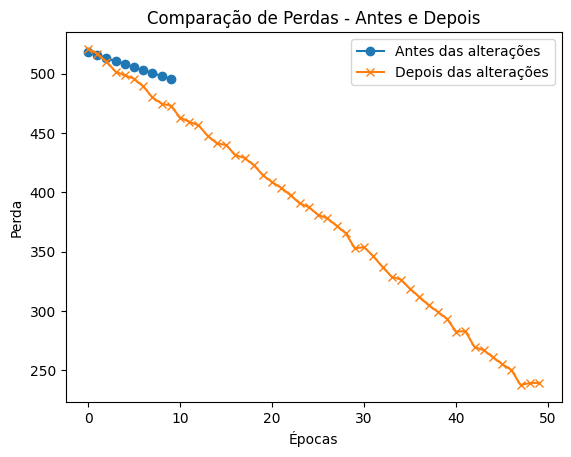

In [163]:
plt.plot(losses, label="Antes das alterações", marker='o') # tem que descomentar no codigo do treinamento 
plt.plot(losses_new, label="Depois das alterações", marker='x')
plt.title("Comparação de Perdas - Antes e Depois")
plt.xlabel("Épocas")
plt.ylabel("Perda")
plt.legend()
plt.show()

>> Nota-se que o modelo com os novos parametros aprende muito mais, reduzindo drasticamente a loss

>> antes da alteração:

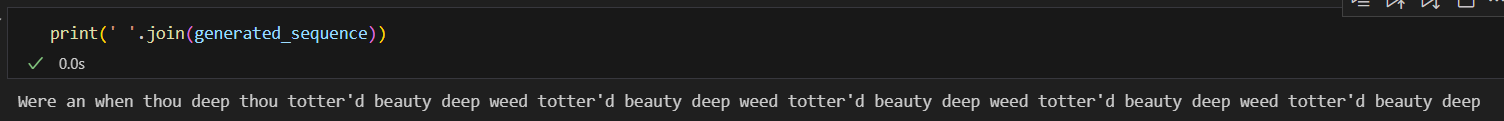

>> depois da alteração:

In [116]:
context = ['Were', 'an']

generated_sequence = model.generate(context, word_to_ix, ix_to_word, max_tokens=128)

print(' '.join(generated_sequence))

Were an all-eating shame, and thriftless thy beauty's field, Thy youth's proud livery so gazed on now, Will be a totter'd weed of thy beauty's use, If thou


>> Nota-se melhoras evidentes nos resultados sendo que o modelo consegue aprender mais rápido e o modelo consegue gerar sentenças mais coerentes e menos repetitivas quando comparada aos resultados antes da melhora.

## Character-Level RNN Language Model

__1 - Escreva a função generate da classe RNN.__

__2 - Escreva as funções de load_dataset, preprocess_data, tokenize_data e create_input.__

__3 - Realize otimização de hiperparâmetros. Justifique a escolha dos hiperparâmetros otimizados e o espaço de busca definido.__

__4 - Adicione uma Layer de Dropout na classe RNN. Treine o novo modelo e argumente sobre o impacto dessa alteração no modelo.__

__5 - Adicione uma nova nn.Layer que recebe como input os vetores hidden e output combinados. Treine o novo modelo e argumente sobre o impacto dessa alteração no modelo.__

__6 - Adicione uma função para printar uma geração de texto de no máximo 100 caracteres sempre que printar a loss do modelo.__

__7 - Adicione uma função que calcula a perplexidade e printe com a loss.__

__8 - Proponha três alterações no código e demonstre que melhorou o desempenho do modelo.__

**Desafio**

__1 - Desenvolva um modelo Word-Level utilizando LSTM.__
- __Escrever a classe LSTM.__
- __Escrever a função generate.__
- __Otimizar o modelo.__
- __Comparar com as outras abordagens acima__

In [164]:
# RNN BASE

import torch
import torch.nn as nn
import torch.nn.functional as F
import random

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        input_combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
    def generate(self, start_char, char_to_ix, ix_to_char, max_length): 

        '''
        é preciso fornecer uma letra pra essa função e assim ela continua adicionando novas letras, uma de cada vez, para formar palavras e tentar formar frases completas. 
        Cada novo caractere que a função escolhe, ela considera todos os caracteres anteriores para decidir qual deve vir a seguir (RNN né),
        baseando-se no que o modelo aprendeu durante seu treinamento.
        '''

        #-> start_char: O caractere inicial 
        #-> char_to_ix: caracteres para índices
        #-> ix_to_char: índices para caracteres.
        #-> max_length: comprimento máximo gerado.

        # inicia a sequência gerada com o caractere inicial
        generated_chars = [start_char]
        input_char = start_char
        hidden = self.initHidden()  #inicializa o hidden state com o caractere inicial 

        for _ in range(max_length):
            # caractere que entra em tensor one-hot
            input_tensor = torch.zeros(1, len(char_to_ix))
            input_tensor[0][char_to_ix[input_char]] = 1

            # passa pelo forward
            output, hidden = self.forward(input_tensor, hidden) # obter a saída e o novo estado oculto a partir da entrada

            output_dist = output.exp() # saída para probabilidades reais
            top_i = torch.multinomial(output_dist, 1)[0]

            # caractere previsto
            predicted_char = ix_to_char[top_i.item()]

            # add o caractere previsto na sequência gerada
            generated_chars.append(predicted_char)

            # att o caractere de entrada para o próximo passo e volta ao inicio do for 
            input_char = predicted_char

        # Junta os caracteres em uma string única e retorna
        return ''.join(generated_chars)

In [261]:
def load_dataset(file_path, percentagem):

    '''
    carregar os dados na quantidade que eu quero
    '''

    with open(file_path, 'r', encoding='utf-8') as f:
        data = f.read()

    # garantia
    if not 0 < percentagem <= 100:
        raise ValueError("errado a porcentagem")

    num_chars = int(len(data) * (percentagem / 100))
    data = data[:num_chars]
    return data


def preprocess_data(data):

    '''
    remover caracteres indesejados, retirar espaços indesejados e converter todos os caracteres para minúsculas
    '''

    data = data.lower()
    # remove os espaços extras e quebras de linha
    data = data.replace('\n', ' ').replace('\r', ' ').strip()
    return data


def tokenize_data(data):

    '''
    divide o texto em pedaços menores, converte o texto limpo em uma lista de índices numéricos. 
    Cada caractere único nesse texto é mapeado para um número, 
    e cada ocorrência desses caracteres é então representada por seu índice na lista.
    '''

    #caracteres para índices e íncides para caracteres
    # ordena de caracteres únicos no texto
    chars = sorted(list(set(data)))
    vocab_len = len(chars) #tamanho desse vocabulário

    # dicionários de mapeamento
    char_to_ix = { ch:i for i,ch in enumerate(chars) } #caracteres para índices
    ix_to_char = { i:ch for i,ch in enumerate(chars) } #índices para caracteres
    # Codifica todo o texto
    data_encoded = [char_to_ix[ch] for ch in data] #texto como lista de índices
    return data_encoded, char_to_ix, ix_to_char


def create_input(data_encoded, seq_length):

    ''' 
    Cria sequencias de entrada e de alvo para o treinamento do modelo. 
    ela desliza uma janela de tamanho seq_length sobre os dados já codificados para criar pares de sequencias de entrada e de alvo.
    '''

    #tensores de entrada
    input_sequences = []
    target_sequences = []

    for i in range(0, len(data_encoded) - seq_length):
        # seq de entrada
        input_seq = data_encoded[i:i+seq_length]
        
        # seq alvo 
        target_seq = data_encoded[i+1:i+seq_length+1]
        input_sequences.append(input_seq)
        target_sequences.append(target_seq)

    # listas de sequências em tensores
    input_tensors = [torch.tensor(seq, dtype=torch.long).unsqueeze(0) for seq in input_sequences]
    target_tensors = [torch.tensor(seq, dtype=torch.long).unsqueeze(0) for seq in target_sequences]

    return input_tensors, target_tensors

def input_target_tensor(data_encoded, start_idx, seq_length):
    # extrai a sequencia da entrda e do alvo a partir do indice de inicio
    input_seq = data_encoded[start_idx:start_idx + seq_length]
    target_seq = data_encoded[start_idx + 1:start_idx + seq_length + 1]

    # sequências em tensores
    input_tensor = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0)
    target_tensor = torch.tensor(target_seq, dtype=torch.long).unsqueeze(0)
    return input_tensor, target_tensor

In [271]:
# Parâmetros do modelo
n_hidden = 128
learning_rate = 0.0015
n_epochs = 150
print_every = 10
percentagem = 0.1  # quanto eu quero do dataset 

# comprimento máximo da sequência
max_sequence_len = 150

In [263]:
# conjunto de dados
file_path = 'shakespeare-data.txt'

data = load_dataset(file_path, percentagem)

# pre processa o texto
data = preprocess_data(data)

# tokeniza no caracter level
data_encoded, char_to_ix, ix_to_char = tokenize_data(data)
vocab_len = len(char_to_ix)

# tensores da entrada e do alvo
input_tensors, target_tensors = create_input(data_encoded, max_sequence_len)

In [266]:
# instancia o modelo, a função de perda e o otimizador
rnn = RNN(vocab_len, n_hidden, vocab_len)
criterion = nn.NLLLoss()
optimizer = optim.Adam(rnn.parameters(), lr=learning_rate)

In [267]:
def train(input_tensor, target_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()
    loss = 0
    seq_len = input_tensor.size(1)
    for i in range(seq_len):
        # índice do caractere em um vetor one-hot
        input_char = F.one_hot(input_tensor[0][i], num_classes=vocab_len).float().unsqueeze(0)
        output, hidden = rnn(input_char, hidden)
        target_char = target_tensor[0][i]
        loss += criterion(output, target_char.unsqueeze(0))

    loss.backward()
    optimizer.step()

    return loss.item() / seq_len

In [229]:
#losses_per_epoch = []
#losses_per_epoch_1 = []
#losses_per_epoch_2 = []
#losses_per_epoch_3 = []
losses_per_epoch_4 = []
for epoch in range(1, n_epochs + 1):
    total_loss = 0
    for start_idx in range(0, len(data_encoded) - max_sequence_len, max_sequence_len):
        input_tensor, target_tensor = input_target_tensor(data_encoded, start_idx, max_sequence_len)
        loss = train(input_tensor, target_tensor)
        total_loss += loss

    losses_per_epoch_4.append(loss)

    if epoch % print_every == 0:
        print(f'Epoch: {epoch}, Loss: {loss}')
        

Epoch: 10, Loss: 2.896478068033854
Epoch: 20, Loss: 2.6114849853515625
Epoch: 30, Loss: 2.1751059977213543
Epoch: 40, Loss: 1.8618422444661458
Epoch: 50, Loss: 1.6205100504557293
Epoch: 60, Loss: 1.4115364583333334
Epoch: 70, Loss: 1.2100336710611979
Epoch: 80, Loss: 1.026053466796875
Epoch: 90, Loss: 0.8711994425455729
Epoch: 100, Loss: 0.738245849609375
Epoch: 110, Loss: 0.5795472717285156
Epoch: 120, Loss: 0.48690144856770834
Epoch: 130, Loss: 0.40584866841634115
Epoch: 140, Loss: 0.2943683115641276
Epoch: 150, Loss: 0.24456591288248697


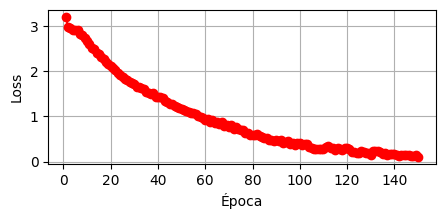

In [209]:
plt.figure(figsize=(5, 2))
plt.plot(range(1, n_epochs + 1), losses_per_epoch_4, marker='o', color='r')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [241]:
# teste de resultado 
start_char = 'b'  # Caractere inicial
generated_text = rnn.generate(start_char, char_to_ix, ix_to_char, max_length=100)
print(generated_text)

but our sity it we kicit us bicctius, ar purerevengers cto utawe lle bees: feralea chalk weod. relold


#### 3 - Realize otimização de hiperparâmetros. Justifique a escolha dos hiperparâmetros otimizados e o espaço de busca definido.

-> losses_per_epoch_original
learning_rate = 0.001
n_epochs = 10
max_sequence_len = 100
/// Texto: b w f,t ioc ,ots  r  sarsrer  iusyee  edzelgn oaa  ltdpasnc,vme tieei tr  oisei t ci ierf  he stwdsty

-> losses_per_epoch_1
learning_rate = 0.0025
n_epochs = 20
max_sequence_len = 250
/// Texto: b?t sev ua mhenutthors enh fit:t est. iaimitizeie bw l'h or shilyrsvegkra firet ass alld:pet: 'e kkre

-> losses_per_epoch_2
learning_rate = 0.001
n_epochs = 100
max_sequence_len = 50
/// Texto: but the superfluity, while it were wholesome, we misy ver le do nus  ha.  farameyesy sof aadsectocist

-> losses_per_epoch_3
learning_rate = 0.001
n_epochs = 200
max_sequence_len = 100
/// Texto: bend.  firsed?  old dgesole ti ul: ise know't.  first citizenser te m arese chais t arlie a'us percic

-> losses_per_epoch_4
learning_rate = 0.0015
n_epochs = 150
max_sequence_len = 150
/// Texto: but they uperk be esere,the abe dkes: wh thime dnun: for are peowec misale cit feremy to recthet aona

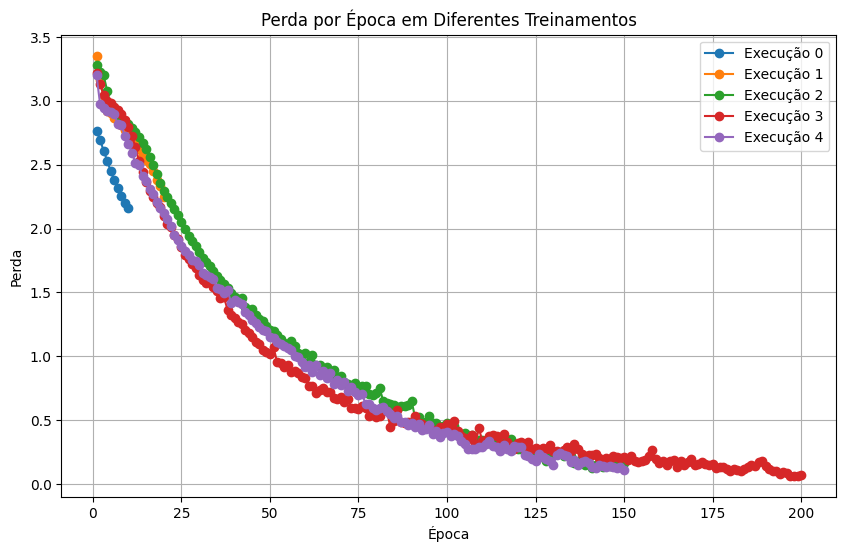

In [224]:
all_losses = [
    ('Execução 0', losses_per_epoch),
    ('Execução 1', losses_per_epoch_1),
    ('Execução 2', losses_per_epoch_2),
    ('Execução 3', losses_per_epoch_3),
    ('Execução 4', losses_per_epoch_4),
]

# ****************************
# PURO SUCO DO GPT ESSE GRÁFICO
# ****************************

# Configurações do gráfico
plt.figure(figsize=(10, 6))

# Itera sobre cada lista de perdas e plota no gráfico
for label, losses in all_losses:
    epochs = range(1, len(losses) + 1)
    plt.plot(epochs, losses, marker='o', label=label)

# Personalização do gráfico
plt.title('Perda por Época em Diferentes Treinamentos')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()
plt.grid(True)

# Exibe o gráfico
plt.show()

>> Comparada a oroginal (Execução 0) qualquer uma é melhor. Porém se analisarmos o texto gerado, o tempo de treinamento e a curva de loss, me arrisco a dizer que a melhor opção foi a Execução 4. A Execução 3 também foi muito boa, porém a 4 com LR um pouco melhor e menos épocas teve um desempenho semelhante. Para o tamanho do dataset treinando, acredito que a 4 é sim a melhor escolha para testar em um dataset ENORME como o disponibilizado. 

#### 4 - Adicione uma Layer de Dropout na classe RNN. Treine o novo modelo e argumente sobre o impacto dessa alteração no modelo.

In [242]:
# RNN BASE

import torch
import torch.nn as nn
import torch.nn.functional as F
import random

dropout_p = 0.3

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.dropout_p = dropout_p #quanto eu quero de dropout
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.dropout = nn.Dropout(self.dropout_p) #add dropout
        self.i2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        input_combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
    def generate(self, start_char, char_to_ix, ix_to_char, max_length): 
        #-> start_char: O caractere inicial 
        #-> char_to_ix: caracteres para índices
        #-> ix_to_char: índices para caracteres.
        #-> max_length: comprimento máximo gerado.

        # inicia a sequência gerada com o caractere inicial
        generated_chars = [start_char]
        input_char = start_char
        hidden = self.initHidden()  #inicializa o hidden state com o caractere inicial 

        for _ in range(max_length):
            # caractere que entra em tensor one-hot
            input_tensor = torch.zeros(1, len(char_to_ix))
            input_tensor[0][char_to_ix[input_char]] = 1

            # passa pelo forward
            output, hidden = self.forward(input_tensor, hidden) # obter a saída e o novo estado oculto a partir da entrada

            output_dist = output.exp() # saída para probabilidades reais
            top_i = torch.multinomial(output_dist, 1)[0]

            # caractere previsto
            predicted_char = ix_to_char[top_i.item()]

            # add o caractere previsto na sequência gerada
            generated_chars.append(predicted_char)

            # att o caractere de entrada para o próximo passo e volta ao inicio do for 
            input_char = predicted_char

        # Junta os caracteres em uma string única e retorna
        return ''.join(generated_chars)

In [243]:
losses_per_epoch_4_drop = []
for epoch in range(1, n_epochs + 1):
    total_loss = 0
    for start_idx in range(0, len(data_encoded) - max_sequence_len, max_sequence_len):
        input_tensor, target_tensor = input_target_tensor(data_encoded, start_idx, max_sequence_len)
        loss = train(input_tensor, target_tensor)
        total_loss += loss

    losses_per_epoch_4_drop.append(loss)

    if epoch % print_every == 0:
        print(f'Epoch: {epoch}, Loss: {loss}')

Epoch: 10, Loss: 0.1845440673828125
Epoch: 20, Loss: 0.13601950327555337
Epoch: 30, Loss: 0.08039564768473308
Epoch: 40, Loss: 0.06428544998168945
Epoch: 50, Loss: 0.37806429545084635
Epoch: 60, Loss: 0.04137791315714518
Epoch: 70, Loss: 0.02736517588297526
Epoch: 80, Loss: 0.02138220469156901
Epoch: 90, Loss: 0.01745392640431722
Epoch: 100, Loss: 0.014617664019266764
Epoch: 110, Loss: 0.012460854848225912
Epoch: 120, Loss: 0.010762866338094075
Epoch: 130, Loss: 0.009392377535502115
Epoch: 140, Loss: 0.008265085220336914
Epoch: 150, Loss: 0.00732385794321696


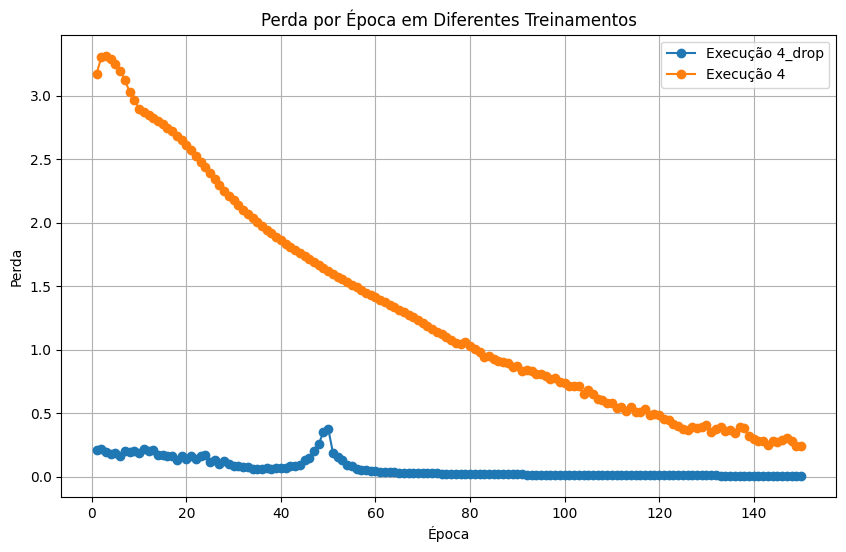

In [244]:
all_losses = [
    ('Execução 4_drop', losses_per_epoch_4_drop),
    ('Execução 4', losses_per_epoch_4),
]
# ****************************
# PURO SUCO DO GPT ESSE GRÁFICO
# ****************************

# Configurações do gráfico
plt.figure(figsize=(10, 6))

# Itera sobre cada lista de perdas e plota no gráfico
for label, losses in all_losses:
    epochs = range(1, len(losses) + 1)
    plt.plot(epochs, losses, marker='o', label=label)

# Personalização do gráfico
plt.title('Perda por Época em Diferentes Treinamentos')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()
plt.grid(True)

# Exibe o gráfico
plt.show()

In [254]:
start_char = 'b'  # Caractere inicial
generated_text = rnn.generate(start_char, char_to_ix, ix_to_char, max_length=100)
print(generated_text)

but the superfluity, while it were wholesome, we might guess they relieved us humanely; but they thin


>> Ao "desligar" aleatoriamente uma porcentagem dos neuronios durante o train, o modelo é forçado a aprender características mais robustas e generalizáveis dos dados, entretanto o que notou-se foi o contrário, devido a quantidade de épocas e ele acabou overfitanto ali próxima da época 70, o teste de geração do texto prova isso, em que as palavras são criadas corretamente, praticamente sem erro. Por que? nao sei, talvez ligada a recursividade do modelo, talvez pela queda brusca da loss no inicio devido menos ajustado às peculiaridades dos dados, quando comparada com o modelo sem drop. 

#### 5 - Adicione uma nova nn.Layer que recebe como input os vetores hidden e output combinados. Treine o novo modelo e argumente sobre o impacto dessa alteração no modelo.

In [265]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(hidden_size, output_size)

        # combinação de hidden e output
        self.ho2o = nn.Linear(hidden_size + output_size, output_size)
        # ----------------------------------------------------------
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        input_combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(hidden)

        #----------------------------------
        # aqui tem que concatenar os vetores hidden e output
        combined = torch.cat((hidden, output), 1)
        # passando na nova camada
        output = self.ho2o(combined)
        #-----------------------------------

        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
    def generate(self, start_char, char_to_ix, ix_to_char, max_length): 
        generated_chars = [start_char]
        input_char = start_char
        hidden = self.initHidden()
    
        for _ in range(max_length):
            input_tensor = torch.zeros(1, len(char_to_ix))
            input_tensor[0][char_to_ix[input_char]] = 1

            output, hidden = self.forward(input_tensor, hidden)

            output_dist = output.exp()
            top_i = torch.multinomial(output_dist, 1)[0]

            predicted_char = ix_to_char[top_i.item()]
            generated_chars.append(predicted_char)
            input_char = predicted_char

        return ''.join(generated_chars)

In [268]:
losses_per_epoch_5_esquisita = []
for epoch in range(1, n_epochs + 1):
    total_loss = 0
    for start_idx in range(0, len(data_encoded) - max_sequence_len, max_sequence_len):
        input_tensor, target_tensor = input_target_tensor(data_encoded, start_idx, max_sequence_len)
        loss = train(input_tensor, target_tensor)
        total_loss += loss

    losses_per_epoch_5_esquisita.append(loss)

    if epoch % print_every == 0:
        print(f'Epoch: {epoch}, Loss: {loss}')

Epoch: 10, Loss: 2.91325927734375
Epoch: 20, Loss: 2.7460030110677085
Epoch: 30, Loss: 2.3628245035807294
Epoch: 40, Loss: 2.015855305989583
Epoch: 50, Loss: 1.7915824381510417
Epoch: 60, Loss: 1.584892781575521
Epoch: 70, Loss: 1.407882588704427
Epoch: 80, Loss: 1.2662862141927083
Epoch: 90, Loss: 1.1263501993815104
Epoch: 100, Loss: 0.9795885213216146
Epoch: 110, Loss: 0.8458641560872396
Epoch: 120, Loss: 0.7132406107584636
Epoch: 130, Loss: 0.5794620259602865
Epoch: 140, Loss: 0.44257670084635414
Epoch: 150, Loss: 0.36651944478352866


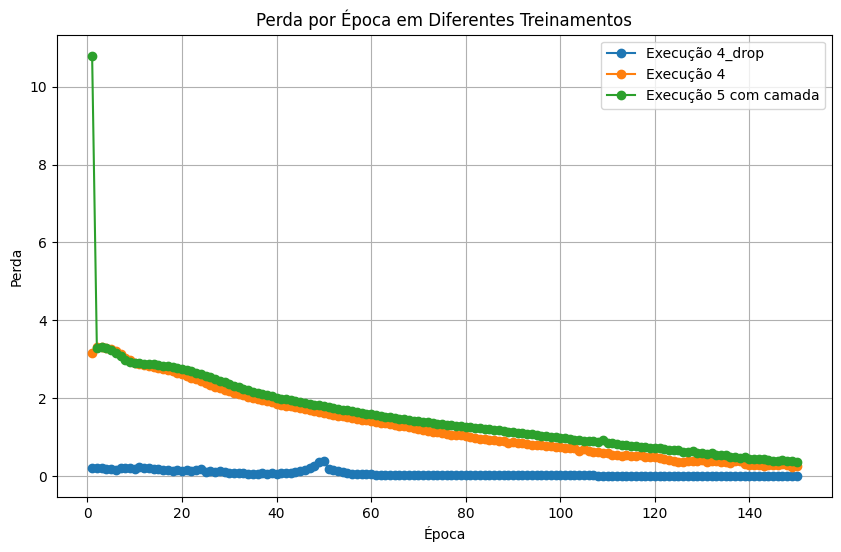

In [269]:
all_losses = [
    ('Execução 4_drop', losses_per_epoch_4_drop),
    ('Execução 4', losses_per_epoch_4),
    ('Execução 5 com camada', losses_per_epoch_5_esquisita),
]
# ****************************
# PURO SUCO DO GPT ESSE GRÁFICO
# ****************************

# Configurações do gráfico
plt.figure(figsize=(10, 6))

# Itera sobre cada lista de perdas e plota no gráfico
for label, losses in all_losses:
    epochs = range(1, len(losses) + 1)
    plt.plot(epochs, losses, marker='o', label=label)

# Personalização do gráfico
plt.title('Perda por Época em Diferentes Treinamentos')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()
plt.grid(True)

# Exibe o gráfico
plt.show()

>> Esse aqui eu confesso que ainda nao entendi ao certo o porque unir os vetores hidden e output. Mas foi feito e o resutlado foi ligeiramente pior que o modelo sem dropout.

#### 6 - Adicione uma função para printar uma geração de texto de no máximo 100 caracteres sempre que printar a loss do modelo.

>> Como não sabia ao certo para qual modeling voces queriam, vou continuar com o da 5, mesmo nao sendo o melhor. 

In [274]:
rnn = RNN(vocab_len, n_hidden, vocab_len)
criterion = nn.NLLLoss()
optimizer = optim.Adam(rnn.parameters(), lr=learning_rate)

losses_per_epoch_5_esquisita = []
for epoch in range(1, n_epochs + 1):
    total_loss = 0
    for start_idx in range(0, len(data_encoded) - max_sequence_len, max_sequence_len):
        input_tensor, target_tensor = input_target_tensor(data_encoded, start_idx, max_sequence_len)
        loss = train(input_tensor, target_tensor)
        total_loss += loss

    losses_per_epoch_5_esquisita.append(loss)

    if epoch % print_every == 0:
        print(f'Epoch: {epoch}, Loss: {loss}')
        generated_text = rnn.generate(start_char, char_to_ix, ix_to_char, max_length=100)
        print(f'Generated text:\n{generated_text}\n')

Epoch: 10, Loss: 2.671107177734375
Generated text:
bkeaf.   wn  ;slecc.fwkpk rirc osuiue k? di sn   s.lutiy nd dty  eanesysedsicee.ncitiyefhenlnzeiu etd

Epoch: 20, Loss: 1.944306640625
Generated text:
bepe oo angom au.ecyt ifet rheleiwt  te prare airecsnobi tae aur cot zsn sorf mezinvs le thv nitkls a

Epoch: 30, Loss: 1.4481736246744792
Generated text:
b re toce and mageoulle we ouvemti: sourd le or thiipthlit ou areshecitizes whew wothey word citiins 

Epoch: 40, Loss: 1.0983238728841145
Generated text:
b, arl heawe t ur to thicitizen:, iws wu courecsthe thifir thi ga sir to yie forsthe you preis, abal:

Epoch: 50, Loss: 0.8804942830403646
Generated text:
blvedney; thit aaveneor me ofrerciticitill, no morety, is firsticitie toou coulerand yie the iuld now

Epoch: 60, Loss: 0.6568002827962239
Generated text:
benowe mishave rsiceabresy cialu rs, ene redous, wit , amt un they uo rerustey puspectiev bufd is't a

Epoch: 70, Loss: 0.42728291829427084
Generated text:
be tous rored for tor 

>> Nota-se que com o passar das épocas as palavras vão tomando mais forma, perdendo os acentos e caracteres especiais. O modelo 5 não é tão bom assim quando comparado aos outros dois disponibilizados acima. Entretanto da pra ver que ta melhorando com o tempo mesmo e prodzindo melhoras nas previsões. 

#### 7 - Adicione uma função que calcula a perplexidade e printe com a loss.

In [275]:
import math

def calculate_perplexity(loss):
    return math.exp(loss)


rnn = RNN(vocab_len, n_hidden, vocab_len)
criterion = nn.NLLLoss()
optimizer = optim.Adam(rnn.parameters(), lr=learning_rate)

losses_per_epoch_5_esquisita = []
for epoch in range(1, n_epochs + 1):
    total_loss = 0
    for start_idx in range(0, len(data_encoded) - max_sequence_len, max_sequence_len):
        input_tensor, target_tensor = input_target_tensor(data_encoded, start_idx, max_sequence_len)
        loss = train(input_tensor, target_tensor)
        total_loss += loss

    losses_per_epoch_5_esquisita.append(loss)

    perplexity = calculate_perplexity(loss)  #função que calcula a perplexidade

    if epoch % print_every == 0:
        print(f'Epoch: {epoch}, Loss: {loss}, , Perplexity: {perplexity}')
        generated_text = rnn.generate(start_char, char_to_ix, ix_to_char, max_length=100)
        print(f'Generated text:\n{generated_text}\n')

Epoch: 10, Loss: 2.8443031819661457, , Perplexity: 17.189576487819306
Generated text:
b!s seerneiik sttiweez okisfhh  ty znienztsw  ot eiy,g  z, ing stiwgehiei iu,o sz rr tou, au:mi.apep.

Epoch: 20, Loss: 2.4008809407552083, , Perplexity: 11.032891424527921
Generated text:
bor tgaowanse d de cyffove tu,d cun zenh wod buk triyglsem ow: nitpoyy vet rnt'e a, g r werd, idh rir

Epoch: 30, Loss: 1.9456667073567708, , Perplexity: 6.998296115516884
Generated text:
bay tit d rese anetgo  lu bacizene? sfitirizan: unt ;hictt don ts iis zins awe caande any ry iulzen: 

Epoch: 40, Loss: 1.6645248413085938, , Perplexity: 5.283162312770216
Generated text:
be t?  fitd on: gue wut el hes ptite tor berd lut,  ns le revediet  aurot ara sa citizens, af arsere 

Epoch: 50, Loss: 1.3941860961914063, , Perplexity: 4.031691827560535
Generated text:
bursthe pore: falle citizen: bofd, they re coundey, on's; burdann: firlles us cheuiry us, cit citiz g

Epoch: 60, Loss: 1.1980672200520834, , Perplexity: 3.31370

>> a perplexidade é uma medida de quão "surpreso" o modelo fica ao ver novos dados, quanto menor a perplexidade, menos surpreso o modelo está pelas entradas, indicando um melhor desempenho. Como da pra ver nesse treinamento esse valor diminui a cada época, indicando a melhoria e indicando que o modelo tem uma alta probabilidade de prever corretamente a próxima palavra. Está bom? não, mas ta bem melhor que as epocas anteriores. 

#### 8 - Proponha três alterações no código e demonstre que melhorou o desempenho do modelo.

>> As mundaçans que vou testar aqui são: 
* Uso de embeddings no lugar de one-hot -> cada caractere agora é um vetor de tamanho 64, capturando informações essenciais e menos dimensões. 
* Aumento do tamanho do hidden state -> esse ajuste ampliará a capacidade do modelo para aprender padrões mais complexos.
* Learning rate dinâmica -> isso faz com que a learning rate seja atualizada após cada época, começando mais agressiva e diminuindo com o tempo

>> OBS: Não vou usar a arquitetura da 5, pois ainda está muito confusa pra mim, logo, estarei usando a execução 4 SEM dropout

In [280]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, embedding_dim)
        #------------------------------
        self.i2h = nn.Linear(embedding_dim + hidden_size, hidden_size)
        #------------------------------
        self.i2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    # tem que mudar na foeward para aceitar a camada de embeddings
    def forward(self, input, hidden):

        #------------------------------
        embedded = self.embedding(input)  
        embedded = embedded.view(1, -1)
        #------------------------------
        
        input_combined = torch.cat((embedded, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(hidden)
        output = self.softmax(output)
        return output, hidden
    

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
    def generate(self, start_char, char_to_ix, ix_to_char, max_length): 
        generated_chars = [start_char]
        input_char = start_char
        hidden = self.initHidden()
    
        for _ in range(max_length):
            
            #--------------------------------------
            #input_tensor = torch.zeros(1, len(char_to_ix))
            #input_tensor[0][char_to_ix[input_char]] = 1
            input_tensor = torch.tensor([char_to_ix[input_char]], dtype=torch.long).unsqueeze(0)
            #--------------------------------------

            output, hidden = self.forward(input_tensor, hidden)

            output_dist = output.exp()
            top_i = torch.multinomial(output_dist, 1)[0]

            predicted_char = ix_to_char[top_i.item()]
            generated_chars.append(predicted_char)
            input_char = predicted_char

        return ''.join(generated_chars)

In [281]:
embedding_dim = 64
n_hidden = 256

In [282]:
def train(input_tensor, target_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()
    loss = 0
    seq_len = input_tensor.size(1)
    for i in range(seq_len):
        
        #input_char = F.one_hot(input_tensor[0][i], num_classes=vocab_len).float().unsqueeze(0)
        input_char = input_tensor[0][i].unsqueeze(0)  

        output, hidden = rnn(input_char, hidden)
        target_char = target_tensor[0][i]
        loss += criterion(output, target_char.unsqueeze(0))
    loss.backward()
    optimizer.step()
    return loss.item() / seq_len

In [283]:
from torch.optim.lr_scheduler import StepLR
optimizer = optim.Adam(rnn.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=20, gamma=0.1)


rnn = RNN(vocab_len, n_hidden, vocab_len)
criterion = nn.NLLLoss()
optimizer = optim.Adam(rnn.parameters(), lr=learning_rate)

losses_per_epoch_6_final = []
for epoch in range(1, n_epochs + 1):
    total_loss = 0
    for start_idx in range(0, len(data_encoded) - max_sequence_len, max_sequence_len):
        input_tensor, target_tensor = input_target_tensor(data_encoded, start_idx, max_sequence_len)
        loss = train(input_tensor, target_tensor)
        total_loss += loss

    losses_per_epoch_6_final.append(loss)

    perplexity = calculate_perplexity(loss)  #função que calcula a perplexidade

    if epoch % print_every == 0:
        print(f'Epoch: {epoch}, Loss: {loss}, , Perplexity: {perplexity}')
        generated_text = rnn.generate(start_char, char_to_ix, ix_to_char, max_length=100)
        print(f'Generated text:\n{generated_text}\n')

Epoch: 10, Loss: 1.2769675699869791, , Perplexity: 3.585749687303945
Generated text:
bu ktrgeit anl: woold wet, uea; wecesw th, fithengood d aspefits an, us'mo die arjhis to,e wathe aeva

Epoch: 20, Loss: 0.7289607747395833, , Perplexity: 2.0729252516334284
Generated text:
be oll: t coln ts cat iuk ngices an, we'ld pnould. nely thit, yille us makell yns knod reakknup at ai

Epoch: 30, Loss: 0.3729065958658854, , Perplexity: 1.4519487154863877
Generated text:
baty uparesulatyy llihev, hore we breat, s, tie  while we know oprocitizen: woulds mfornea. whalls ou

Epoch: 40, Loss: 0.2135418701171875, , Perplexity: 1.2380553347048282
Generated text:
bun the sue revengers levenge thon wo prorecoungeds thiy ti knew  ti famirevean hralaty, wor: whalgar

Epoch: 50, Loss: 0.1424499003092448, , Perplexity: 1.153095309791791
Generated text:
but the supthit ain away!  socferity  arieed cond,cit; our pitizdnug: fbutd ciuspeares kis  ciin an o

Epoch: 60, Loss: 0.18906782786051432, , Perplexity: 1.208

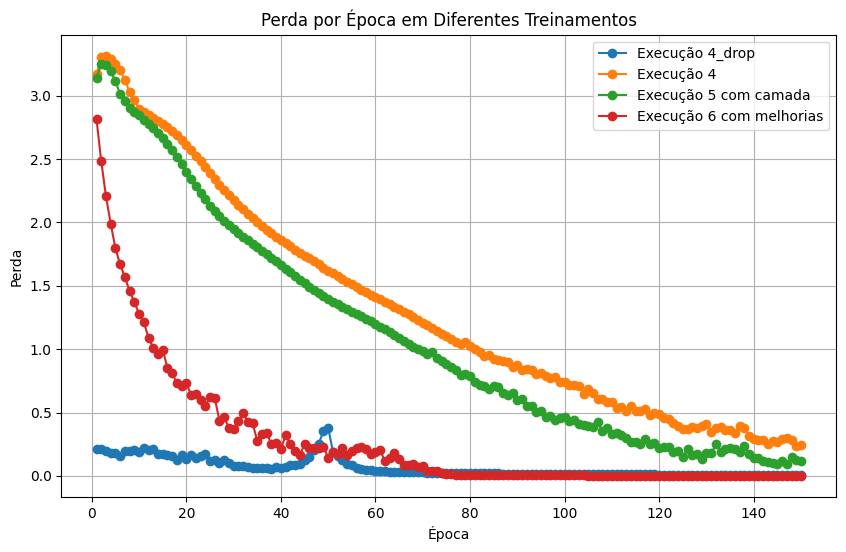

In [298]:
all_losses = [
    ('Execução 4_drop', losses_per_epoch_4_drop),
    ('Execução 4', losses_per_epoch_4),
    ('Execução 5 com camada', losses_per_epoch_5_esquisita),
    ('Execução 6 com melhorias', losses_per_epoch_6_final)
]
# ****************************
# PURO SUCO DO GPT ESSE GRÁFICO
# ****************************

# Configurações do gráfico
plt.figure(figsize=(10, 6))

# Itera sobre cada lista de perdas e plota no gráfico
for label, losses in all_losses:
    epochs = range(1, len(losses) + 1)
    plt.plot(epochs, losses, marker='o', label=label)

# Personalização do gráfico
plt.title('Perda por Época em Diferentes Treinamentos')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()
plt.grid(True)

# Exibe o gráfico
plt.show()

>> Losses abaixando, perplaxity abaixando também, temos um indicativo de aprendizagem. Com essas mundaças pude obter praticamente o mesmo desempenho do execução COM droout, fazendo o modelo overfittar ali proximo da época 70. Lembrando que eu estava comparando a perfomance da Execução 4, tanto pelo gráfico quanto pela geração dos textos claramente teve uma melhora siginificativa. 

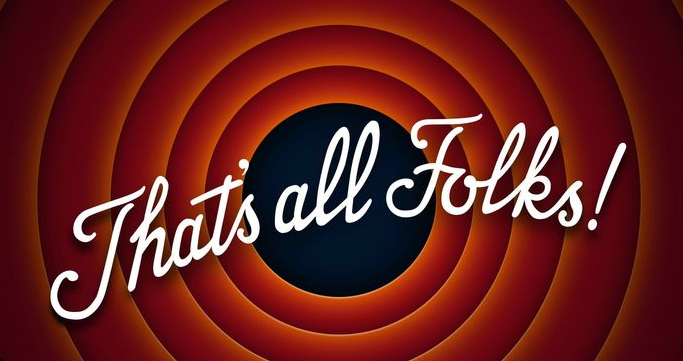